In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# ==============================================================================
# CONFIGURATION
# ==============================================================================
# Path to your raw dataset with train/val splits
SOURCE_DATA_DIR = '/content/drive/MyDrive/fire_datasets/SYNFIRE/dataset'

# Path where the new, prepared dataset will be saved
OUTPUT_DATA_DIR = '/content/drive/MyDrive/fire_datasets/SYNFIRE/dataset'

# Number of 'no-fire' samples to extract from each image
NUM_NEGATIVE_SAMPLES = 3

# Size of the cropped images to save
CROP_SIZE = (224, 224)

# ==============================================================================
# THE PREPROCESSING SCRIPT
# ==============================================================================
def preprocess_dataset(source_base, output_base):
    """
    Processes images and masks to create a classification dataset.
    - Finds fire regions from masks and saves them as 'fire' samples.
    - Extracts random non-fire regions as 'no-fire' samples.
    """
    # Use the main source directory directly
    print(f"Processing dataset from '{source_base}'...")

    source_img_dir = os.path.join(source_base, 'imgs')
    source_mask_dir = os.path.join(source_base, 'masks')

    output_fire_dir = os.path.join(output_base, 'fire')
    output_nofire_dir = os.path.join(output_base, 'no-fire')

    # Create the output directories if they don't exist
    os.makedirs(output_fire_dir, exist_ok=True)
    os.makedirs(output_nofire_dir, exist_ok=True)

    # Check if source directories exist before proceeding
    if not os.path.exists(source_img_dir):
        print(f"Error: Image directory not found at {source_img_dir}")
        return
    if not os.path.exists(source_mask_dir):
        print(f"Error: Mask directory not found at {source_mask_dir}")
        return

    image_files = os.listdir(source_img_dir)

    for img_filename in tqdm(image_files, desc=f"Processing images"):
        img_path = os.path.join(source_img_dir, img_filename)
        # Assume mask has the same name, but might be a different extension (e.g., .png)
        mask_filename = os.path.splitext(img_filename)[0] + '.png'
        mask_path = os.path.join(source_mask_dir, mask_filename)

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        # --- 1. Find and save 'fire' samples ---
        # Find contours of the fire regions in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        fire_boxes = []
        for i, contour in enumerate(contours):
            if cv2.contourArea(contour) > 100: # Filter out very small areas
                x, y, w, h = cv2.boundingRect(contour)
                fire_boxes.append((x, y, w, h))

                # Crop the fire region from the original image
                fire_crop = img[y:y+h, x:x+w]

                # Resize and save
                fire_crop_resized = cv2.resize(fire_crop, CROP_SIZE)
                save_path = os.path.join(output_fire_dir, f"{os.path.splitext(img_filename)[0]}_fire_{i}.jpg")
                cv2.imwrite(save_path, fire_crop_resized)

        # --- 2. Find and save 'no-fire' samples ---
        h, w, _ = img.shape
        attempts = 0
        saved_negatives = 0
        while saved_negatives < NUM_NEGATIVE_SAMPLES and attempts < 20:
            attempts += 1

            # Get a random crop
            rand_x = np.random.randint(0, w - CROP_SIZE[0]) if w > CROP_SIZE[0] else 0
            rand_y = np.random.randint(0, h - CROP_SIZE[1]) if h > CROP_SIZE[1] else 0

            # Check if this random crop overlaps with any fire box
            is_overlap = False
            for (fx, fy, fw, fh) in fire_boxes:
                # Simple intersection check
                if not (rand_x + CROP_SIZE[0] < fx or rand_x > fx + fw or rand_y + CROP_SIZE[1] < fy or rand_y > fy + fh):
                    is_overlap = True
                    break

            if not is_overlap:
                no_fire_crop = img[rand_y:rand_y+CROP_SIZE[1], rand_x:rand_x+CROP_SIZE[0]]
                save_path = os.path.join(output_nofire_dir, f"{os.path.splitext(img_filename)[0]}_nofire_{saved_negatives}.jpg")
                cv2.imwrite(save_path, no_fire_crop)
                saved_negatives += 1


if __name__ == '__main__':
    preprocess_dataset(SOURCE_DATA_DIR, OUTPUT_DATA_DIR)
    print("\nPreprocessing complete!")
    print(f"Dataset saved to: {OUTPUT_DATA_DIR}")

Processing dataset from '/content/drive/MyDrive/fire_datasets/SYNFIRE/dataset'...


Processing images: 100%|██████████| 2030/2030 [35:37<00:00,  1.05s/it]


Preprocessing complete!
Dataset saved to: /content/drive/MyDrive/fire_datasets/SYNFIRE/dataset


In [ ]:
# Path to your PREPARED dataset with 'fire' and 'no-fire' subfolders
DATA_DIR = '/content/drive/MyDrive/fire_datasets/SYNFIRE/dataset/train'

# Start with the first model
MODEL_NAME = 'resnet18'

# Number of epochs
NUM_EPOCHS = 20

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import time

# ==============================================================================
# 1. SETUP (This will use the variables from your previous cell)
# ==============================================================================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Preparing to train {MODEL_NAME} for {NUM_EPOCHS} epochs.")

# ==============================================================================
# 2. DATA LOADING AND TRANSFORMS
# ==============================================================================
# Standard transformations for pre-trained models
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# We need to create a train/validation split from your prepared data
# Let's assume an 80/20 split.
full_dataset = datasets.ImageFolder(DATA_DIR, data_transforms['train']) # Apply training transforms for now
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# IMPORTANT: We apply the validation transform to the validation set
val_dataset.dataset.transform = data_transforms['val']

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
print(f"Dataset sizes: Train={dataset_sizes['train']}, Val={dataset_sizes['val']}")

# ==============================================================================
# 3. MODEL DEFINITION
# ==============================================================================
# Load the specified ResNet model with pre-trained weights
if MODEL_NAME == 'resnet18':
    model = models.resnet18(weights='IMAGENET1K_V1')
elif MODEL_NAME == 'resnet50':
    model = models.resnet50(weights='IMAGENET1K_V1')
else:
    raise ValueError("Model name not recognized. Choose 'resnet18' or 'resnet50'.")

# Replace the final layer for our 2-class problem (fire, no-fire)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

# ==============================================================================
# 4. TRAINING CONFIGURATION
# ==============================================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==============================================================================
# 5. TRAINING AND VALIDATION LOOP
# ==============================================================================
best_val_accuracy = 0.0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # ✅ Save the best model based on validation accuracy
        if phase == 'val' and epoch_acc > best_val_accuracy:
            best_val_accuracy = epoch_acc
            # Save the model weights to your Google Drive
            save_path = f'/content/drive/MyDrive/{MODEL_NAME}_best.pt'
            torch.save(model.state_dict(), save_path)
            print(f'💾 New best model saved to {save_path} with accuracy: {best_val_accuracy:.4f}')

end_time = time.time()
training_duration = end_time - start_time
print(f'\nTraining complete in {training_duration // 60:.0f}m {training_duration % 60:.0f}s')
print(f'Best validation accuracy: {best_val_accuracy:.4f}')

Using device: cuda:0
Preparing to train resnet50 for 10 epochs.
Dataset sizes: Train=8517, Val=2130
Epoch 1/10
----------


Train Phase: 100%|██████████| 267/267 [01:39<00:00,  2.68it/s]


Train Loss: 0.1121 Acc: 0.9688


Val Phase: 100%|██████████| 67/67 [00:11<00:00,  5.59it/s]


Val Loss: 0.0886 Acc: 0.9765
💾 New best model saved to /content/drive/MyDrive/resnet50_best.pt with accuracy: 0.9765
Epoch 2/10
----------


Train Phase: 100%|██████████| 267/267 [01:28<00:00,  3.02it/s]


Train Loss: 0.0771 Acc: 0.9777


Val Phase: 100%|██████████| 67/67 [00:11<00:00,  5.81it/s]


Val Loss: 0.1099 Acc: 0.9784
💾 New best model saved to /content/drive/MyDrive/resnet50_best.pt with accuracy: 0.9784
Epoch 3/10
----------


Train Phase: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Train Loss: 0.0726 Acc: 0.9802


Val Phase: 100%|██████████| 67/67 [00:11<00:00,  5.65it/s]


Val Loss: 0.0819 Acc: 0.9798
💾 New best model saved to /content/drive/MyDrive/resnet50_best.pt with accuracy: 0.9798
Epoch 4/10
----------


Train Phase: 100%|██████████| 267/267 [01:29<00:00,  2.97it/s]


Train Loss: 0.0590 Acc: 0.9824


Val Phase: 100%|██████████| 67/67 [00:11<00:00,  5.98it/s]


Val Loss: 0.0622 Acc: 0.9822
💾 New best model saved to /content/drive/MyDrive/resnet50_best.pt with accuracy: 0.9822
Epoch 5/10
----------


Train Phase: 100%|██████████| 267/267 [01:30<00:00,  2.93it/s]


Train Loss: 0.0616 Acc: 0.9800


Val Phase: 100%|██████████| 67/67 [00:11<00:00,  5.68it/s]


Val Loss: 0.0548 Acc: 0.9817
Epoch 6/10
----------


Train Phase: 100%|██████████| 267/267 [01:28<00:00,  3.03it/s]


Train Loss: 0.0477 Acc: 0.9850


Val Phase: 100%|██████████| 67/67 [00:10<00:00,  6.17it/s]


Val Loss: 0.0488 Acc: 0.9836
💾 New best model saved to /content/drive/MyDrive/resnet50_best.pt with accuracy: 0.9836
Epoch 7/10
----------


Train Phase: 100%|██████████| 267/267 [01:30<00:00,  2.95it/s]


Train Loss: 0.0543 Acc: 0.9836


Val Phase: 100%|██████████| 67/67 [00:11<00:00,  5.59it/s]


Val Loss: 0.0635 Acc: 0.9822
Epoch 8/10
----------


Train Phase: 100%|██████████| 267/267 [01:28<00:00,  3.03it/s]


Train Loss: 0.0480 Acc: 0.9843


Val Phase: 100%|██████████| 67/67 [00:11<00:00,  5.64it/s]


Val Loss: 0.0658 Acc: 0.9798
Epoch 9/10
----------


Train Phase: 100%|██████████| 267/267 [01:28<00:00,  3.02it/s]


Train Loss: 0.0436 Acc: 0.9847


Val Phase: 100%|██████████| 67/67 [00:13<00:00,  5.09it/s]


Val Loss: 0.0743 Acc: 0.9784
Epoch 10/10
----------


Train Phase: 100%|██████████| 267/267 [01:28<00:00,  3.03it/s]


Train Loss: 0.0498 Acc: 0.9827


Val Phase: 100%|██████████| 67/67 [00:11<00:00,  5.65it/s]

Val Loss: 0.0547 Acc: 0.9812

Training complete in 17m 4s
Best validation accuracy: 0.9836


In [ ]:
# Path to your PREPARED dataset with 'fire' and 'no-fire' subfolders
DATA_DIR = '/content/drive/MyDrive/fire_datasets/SYNFIRE/dataset/train'

# Start with the first model
MODEL_NAME = 'resnet50'

# Number of epochs
NUM_EPOCHS = 10

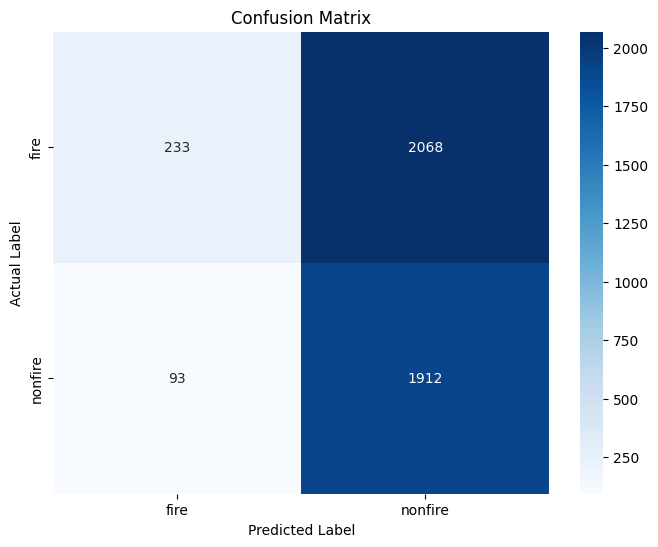

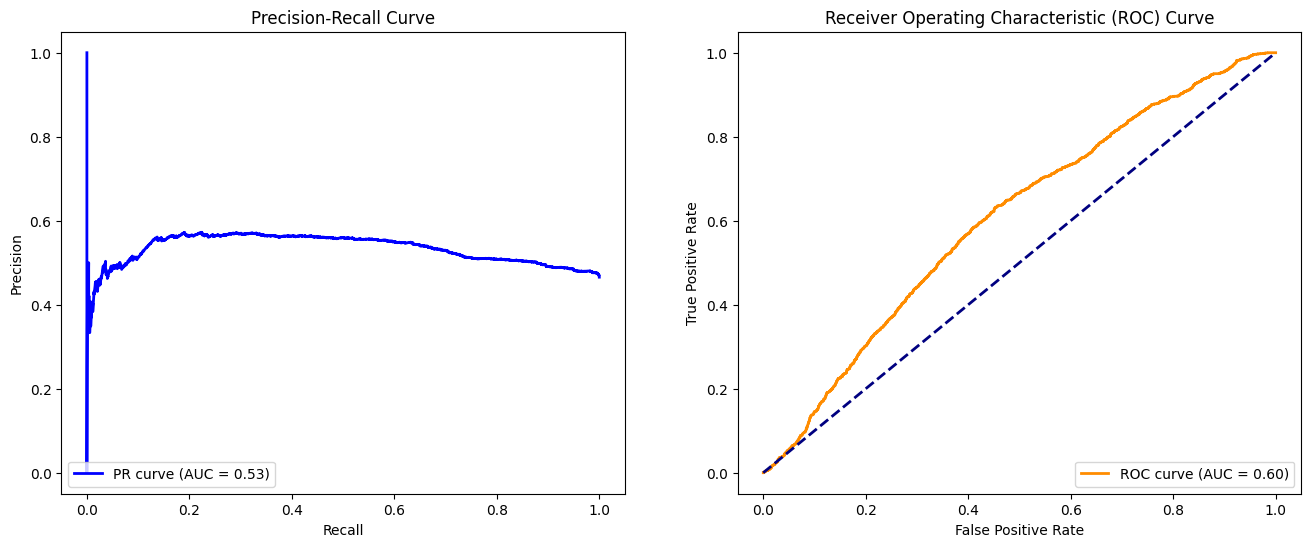

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import torch.nn as nn # Import nn module

# --- CONFIGURATION ---
MODEL_NAME = 'resnet50' # Changed to 'resnet50' to match saved weights
MODEL_WEIGHTS_PATH = f'/content/drive/MyDrive/resnet50_best.pt' # Changed path to resnet50 weights
# !! IMPORTANT: This path should be to your D-FIRE TEST SET !!
TEST_DATA_DIR = '/content/drive/MyDrive/dfire_colab/dfire_cls/test'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- LOAD THE MODEL ---
if MODEL_NAME == 'resnet18':
    model = models.resnet18()
elif MODEL_NAME == 'resnet50':
    model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# --- LOAD THE TEST DATA ---
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(TEST_DATA_DIR, test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes

# --- GET PREDICTIONS ---
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1] # Probability of 'fire' class
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# --- PLOT CONFUSION MATRIX ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- PLOT PR and ROC CURVES ---
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# PR Curve
ax1.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:0.2f})')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend(loc='lower left')

# ROC Curve
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc='lower right')

plt.show()

In [ ]:
OUTPUT_DIR = '/content/drive/MyDrive/model_eval'
fig.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')

**Understanding `torchvision.datasets.ImageFolder`:**

`ImageFolder` is a convenient dataset loader provided by `torchvision` that assumes your image data is organized in a specific way on disk:

In [ ]:
fig.savefig(os.path.join(OUTPUT_DIR, 'performance_curves.png'), dpi=300, bbox_inches='tight')